In [5]:
# 2-2. 프로젝트 2 : 날씨 좋은 월요일 오후 세 시, 자전거 타는 사람은 몇 명?

# 평가기준
# 2. 프로젝트 2의 회귀모델 예측정확도가 기준 이상 높게 나왔는가?
# RMSE 값 150 이하를 달성
# 3. 시각화 요구사항이 정확하게 이루어졌는가?
# 각 프로젝트 진행 과정에서 요구하고 있는 데이터개수 시각화 및 예측결과 시각화를 모두 진행하였다.

# 코드 피어를 위한 내용
# 여러 프로젝트 중, 그날의 마지막 프로젝트만 코드 피어의 대상임
# 상대방을 이해시킬 수 있도록, 쉬운 코드 + 주석 달기
## 모델, loss, 평가지표 선정 이유
# 데이터 분할하기, 하이퍼 파라미터 변경해가며 시도하기, 시각화하기, 실험 결과 기록하기
# 배운 점, 아쉬운 점, 느낀 점, 어려웠던 점 회고 작성하기

# 프로젝트의 목적
# 총 임대 수인 count 예측

# 라이브러리 불러오기 -----------------------------------------------------------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np


In [6]:
# 라이브러리 까는 것, 한번만 하면 됨
# %pip install sweetviz 
# %pip install numpy
# %pip install pandas
# %pip install matplotlib
# %pip install seaborn
# %pip install scikit-learn
# %pip install --upgrade setuptools
# %pip install --upgrade pip

In [7]:
# 데이터 불러오기 -----------------------------------------------------------------------------------------------------
raw_train = pd.read_csv('./data/train.csv')
raw_test = pd.read_csv('./data/test.csv')

print(raw_train.head())
print(raw_test.head())

              datetime  season  holiday  workingday  weather  temp   atemp  \
0  2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1  2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2  2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
3  2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
4  2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

   humidity  windspeed  casual  registered  count  
0        81        0.0       3          13     16  
1        80        0.0       8          32     40  
2        80        0.0       5          27     32  
3        75        0.0       3          10     13  
4        75        0.0       0           1      1  
              datetime  season  holiday  workingday  weather   temp   atemp  \
0  2011-01-20 00:00:00       1        0           1        1  10.66  11.365   
1  2011-01-20 01:00:00       1        0           1        1 

In [8]:
# EDA 보고서 생성 -----------------------------------------------------------------------------------------------------
# 결측치, 이상치, 데이터 분포, 상관관계 등을 확인 가능
# 한번만 하면 됨 
# import sweetviz as sv
# raw_train_re = raw_train.rename(columns={'count': 'count_re'}) # sweetviz라이브러리를 쓰려면, 'count'라는 컬럼명이 있으면 안되므로. 변경함
# sv.analyze(raw_train_re).show_html("eda_train.html")
# sv.analyze(raw_test).show_html("eda_test.html")

In [9]:
# 데이터 컬럼 이해, EDA를 위해 필수적인 과정
# datetime - 시간별 날짜 + 타임스탬프
# season  - 1 = 봄, 2 = 여름, 3 = 가을, 4 = 겨울
# holiday  - 해당 날짜가 휴일로 간주되는지 여부
# workingday  - 해당 날짜가 주말이나 휴일이 아닌지 여부
# weather
## 1: 맑음, 거의 없음 구름, 약간 흐림, 약간 흐림
## 2: 안개 + 흐림, 안개 + 부서진 구름, 안개 + 약간의 구름, 안개
## 3: 가벼운 눈, 가벼운 비 + 뇌우 + 흩어진 구름, 가벼운 비 + 흩어진 구름
## 4: 폭우 + 얼음 팔레트 + 뇌우 + 안개, 눈 + 안개
# temp  - 섭씨 온도
# atemp - "느낌" 온도(섭씨)
# humidity  - 상대 습도, 0인 경우가 매우 드믈지만 가능하다고 함
# windspeed  - 풍속
# casual  - 해당 날짜의 미등록 사용자 대여 수 = 비회원인듯 = train에만 있음
# registered - 해당 날짜의 등록된 사용자 대여 시작 수 = 회원인듯 = train에만 있음
# count - 총 임대 수 = train에만 있음

# 데이터 타입 확인
# train, test 데이터에서 같은 컬럼명의 dtype은 같음, 같게 처리해주면 될 듯
# datetime이 object임
# season, holiday, workingday, weather는 범주형인데, int64로 되어있음, GPT 에 문의했을때는 모델이 학습할때 알아서 구분할 수 있다고는 하는데? test해봐야겠음
print(raw_train.dtypes)
print(raw_test.dtypes)

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object
datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
dtype: object


In [10]:
# 데이터 전처리 -----------------------------------------------------------------------------------------------------
# datetime 컬럼을 년, 월, 일, 시간, 분, 초로 나누기
raw_train['datetime'] = pd.to_datetime(raw_train['datetime'])
raw_test['datetime'] = pd.to_datetime(raw_test['datetime'])

# 추출할 시간 단위
time_units = ['year', 'month', 'day', 'hour', 'minute', 'second']

# 각 시간 단위를 추출하여 새로운 컬럼으로 추가
# raw_train['일시'] = raw_train['datetime'].dt.일시 <- 이걸 반복한 거라 보면 됨
for unit in time_units:
    raw_train[unit] = getattr(raw_train['datetime'].dt, unit)
    raw_test[unit] = getattr(raw_test['datetime'].dt, unit)

# 범주형 변수 category로 변경
# season, holiday, workingday, weather
raw_train['season_c'] = raw_train['season'].astype('category')
raw_train['holiday_c'] = raw_train['holiday'].astype('category')
raw_train['workingday_c'] = raw_train['workingday'].astype('category')
raw_train['weather_c'] = raw_train['weather'].astype('category')

# 날짜로 요일 구하기
raw_train['dayofweek'] = raw_train['datetime'].dt.dayofweek

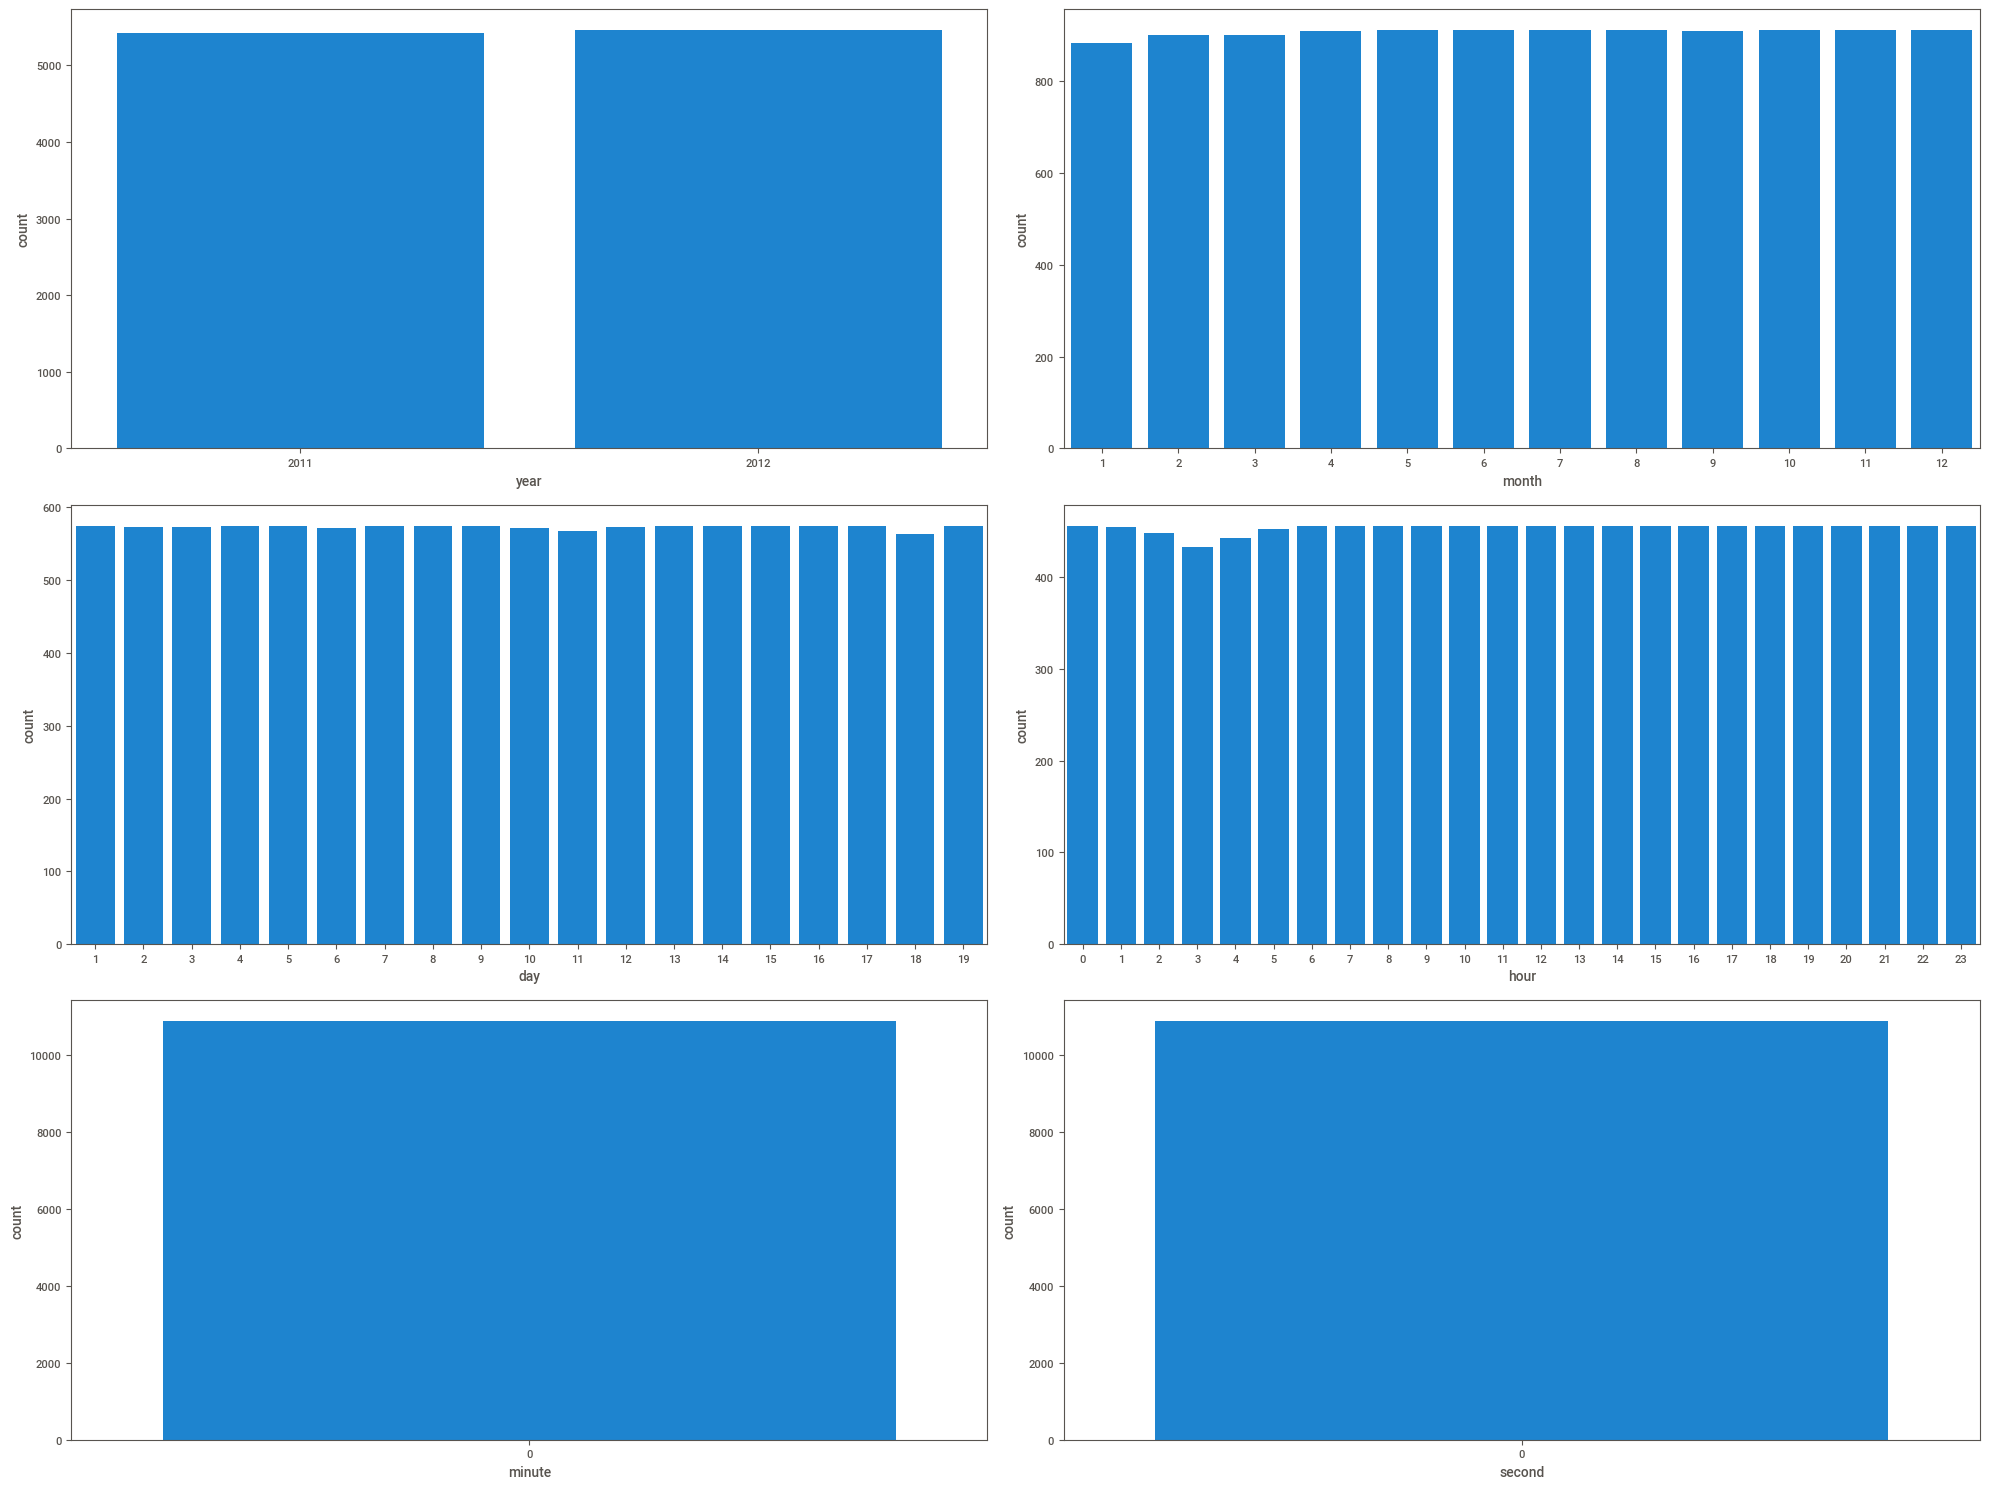

In [11]:
# year, month, day, hour, minute, second 데이터 개수 시각화하기 -----------------------------------------------------------------
# 시각화할 컬럼 목록
columns = ['year', 'month', 'day', 'hour', 'minute', 'second']

# 서브플롯 생성
fig, axes = plt.subplots(3, 2, figsize=(20, 15))

# 서브플롯에 countplot 그리기
# sns.countplot(data=raw_train, x='컬럼명', ax=axes[0, 0]) <- 이걸 반복한 거라 보면 됨
for ax, col in zip(axes.flatten(), columns):
    sns.countplot(data=raw_train, x=col, ax=ax)

# 그래프 레이아웃 조정
plt.tight_layout()
plt.show()

In [12]:
# 데이터 분할하기 -----------------------------------------------------------------------------------------------------
x1 = raw_train[['dayofweek', 'hour', 'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed']]
y = raw_train['count']

X1_train, X1_test, y_train, y_test = train_test_split(x1, y, test_size=0.2, random_state=1004)

x2 = raw_train[['dayofweek', 'hour','season_c', 'holiday_c', 'workingday_c', 'weather_c', 'temp', 'atemp', 'humidity', 'windspeed']]
X2_train, X2_test, y_train, y_test = train_test_split(x2, y, test_size=0.2, random_state=1004)

In [13]:
# 모델링 -----------------------------------------------------------------------------------------------------
# LinearRegression 모델 학습
model1 = LinearRegression()
model1.fit(X1_train, y_train)

model2 = LinearRegression()
model2.fit(X2_train, y_train)

# 예측
pred1 = model1.predict(X1_test)
pred2 = model2.predict(X2_test)

# 평가
mse1 = mean_squared_error(y_test, pred1)
rmse1 = np.sqrt(mse1)

mse2 = mean_squared_error(y_test, pred2)
rmse2 = np.sqrt(mse2)

print(mse1, mse2, rmse1, rmse2) # 똑같네!

22480.756954382763 22480.756954382763 149.935842794119 149.935842794119


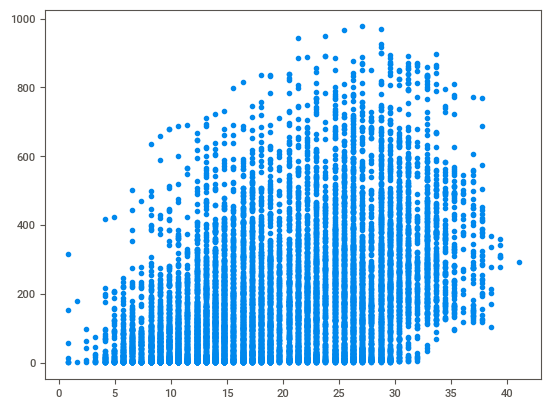

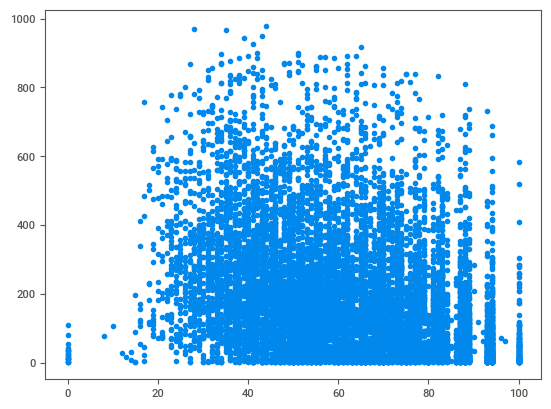

In [14]:
# 시각화 -----------------------------------------------------------------------------------------------------
# x축에 temp 컬럼과 y 축에 count 컬럼의 관계 시각화
plt.clf() # plt 초기화
plt.scatter(raw_train['temp'], raw_train['count'])
plt.show()

# humidity 컬럼과 count 컬럼의 관계 시각화
plt.clf() # plt 초기화
plt.scatter(raw_train['humidity'], raw_train['count'])
plt.show()

In [16]:
# 회고 -----------------------------------------------------------------------------------------------------
# 배운 점
# 코드에 익숙해짐, 범주형을 category로 바꾸지 않아도 된다는걸 배움 (물론 범위를 사용해서 변수를 바꾸면 더 좋을 수도 있음 - ex. 오전 오후)

# 아쉬운 점
# 더 좋은 결과를 얻기 위해 뭘 해야 할지 생각이 잘 나지는 않더라

# 느낀 점
# 다들 똑똑하다

# 어려웠던 점
# 시각화 코드
